# C2: Flight Delay Prediction (over 15 minutes) - Score metric is ROC AUC
# DNN

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

## Import Data

In [38]:
df_train = pd.read_csv('flight_delays_train.csv')
df_test = pd.read_csv('flight_delays_test.csv')
df_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


## Quantify Data

In [39]:
# Train Set
df_train.Month = df_train.Month.str.split('-', expand=True)[1].astype(int)
df_train.DayofMonth = df_train.DayofMonth.str.split('-', expand=True)[1].astype(int)
df_train.DayOfWeek = df_train.DayOfWeek.str.split('-', expand=True)[1].astype(int)

# Test Set
df_test.Month = df_test.Month.str.split('-', expand=True)[1].astype(int)
df_test.DayofMonth = df_test.DayofMonth.str.split('-', expand=True)[1].astype(int)
df_test.DayOfWeek = df_test.DayOfWeek.str.split('-', expand=True)[1].astype(int)

In [40]:
# Function to replace string variables with numbers based on counts
def replace_with_counts(df, columns):
    for column in columns:
        counts = df[column].value_counts().rank(method='dense', ascending=False).astype(float)
        df[column] = df[column].map(counts)
    return df

# Apply the transformation to the specified columns
columns_to_transform = ['UniqueCarrier', 'Origin', 'Dest']
df_train = replace_with_counts(df_train, columns_to_transform)
df_test = replace_with_counts(df_test, columns_to_transform)

In [41]:
df_train['dep_delayed_15min'] = df_train['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0).astype(float)

## Split the Data

In [42]:
X = df_train.drop('dep_delayed_15min', axis=1)
y = df_train.dep_delayed_15min

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
X_test = df_test

## Normalization

In [153]:
# PUT THE SCALER
scaler = MinMaxScaler()

X1 = scaler.fit_transform(X)

#scaler2 = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

X_test = scaler.transform(X_test)

## Model Creation

In [194]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=[8]),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

C:\Users\sajad\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [195]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

In [196]:
hist = model.fit(X1, y, epochs=3)

Epoch 1/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - auc_46: 0.5533 - loss: 0.4969
Epoch 2/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - auc_46: 0.6803 - loss: 0.4571
Epoch 3/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - auc_46: 0.6821 - loss: 0.4564


## Visualization

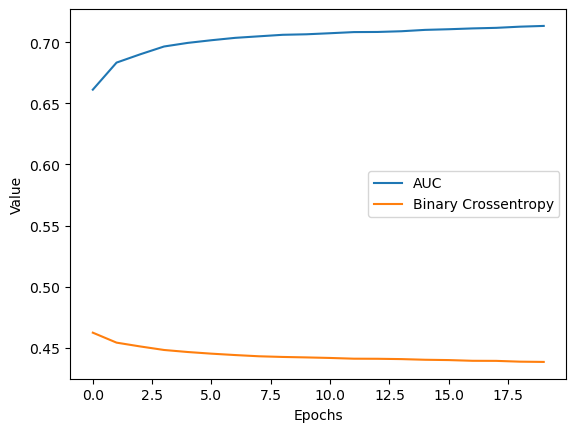

In [173]:
plt.figure()
plt.plot(hist.history['auc_40'])
plt.plot(hist.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(['AUC', 'Binary Crossentropy'])
plt.show()

## Make Predictions

In [174]:
predictions = model.predict(X_test)
predictions = predictions.reshape(100000,)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [175]:
predictions[:20]

array([0.03987135, 0.04322598, 0.03321957, 0.29754585, 0.19235872,
       0.0729089 , 0.05730508, 0.14957386, 0.13909769, 0.25861293,
       0.22422153, 0.1417311 , 0.08546493, 0.17598958, 0.08683538,
       0.25997353, 0.122371  , 0.26107377, 0.32256016, 0.01914677],
      dtype=float32)

In [176]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'id':pd.read_csv('sample_submission.csv').id,'dep_delayed_15min':prediction})
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  print('A submission file has been made')

make_submission(predictions,'submission(v02)')

A submission file has been made


In [178]:
df_train.corr()['dep_delayed_15min']

Month                0.016998
DayofMonth           0.025842
DayOfWeek            0.010439
DepTime              0.243819
UniqueCarrier       -0.004829
Origin              -0.041927
Dest                 0.017317
Distance            -0.002734
dep_delayed_15min    1.000000
Name: dep_delayed_15min, dtype: float64